# Определение стоимости автомобилей

Цель -- определить стоимость авто по его параметрам. 

Помимо качества, необходимо учесть:
- скорость предсказания (быстрая для пользователей)
- время обучения (наверное может быть и подольше, поставим ограничение в 50 минут)
\
\
Использовать как минимум одну модель не бустинга\
Метрика RMSE\
Модель бустинга LightGBM 

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import time



from sklearn.dummy import DummyRegressor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV


from statistics import mean

from lightgbm import LGBMRegressor

import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:     
    df = pd.read_csv('D:/Рабочий стол/япроект/autos.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Наш датасет довольно большой — 350 тыс строк

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df['DateCrawled'].describe()

count                  354369
unique                 271174
top       2016-03-24 14:49:47
freq                        7
Name: DateCrawled, dtype: object

### Удаление неинформативных признаков

Судя по всему, самые неинформативные признаки для анализа это DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode, LastSeen

In [6]:
df = df.loc[:, 'Price':'Repaired']
df = df.drop('RegistrationMonth', axis = 1)

### Пропущенные значения

In [7]:
df.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
dtype: int64

Пропущенные значения есть в пяти столбцах

**VehicleType**

Пропущенных значений довольно много. Посмотрим, какой самый частый тип кузова:

In [8]:
df.groupby('VehicleType')['VehicleType'].count().sort_values(ascending=False)

VehicleType
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

Логично, что седан будет самым распросстраненным

In [9]:
df[df['VehicleType'].isna()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
16,300,NaN,2016,NaN,60,polo,150000,petrol,volkswagen,NaN
22,2900,NaN,2018,manual,90,meriva,150000,petrol,opel,no
26,5555,NaN,2017,manual,125,c4,125000,NaN,citroen,no
31,899,NaN,2016,manual,60,clio,150000,petrol,renault,NaN
...,...,...,...,...,...,...,...,...,...,...
354346,2600,NaN,2005,auto,0,c_klasse,150000,NaN,mercedes_benz,NaN
354351,1900,NaN,2000,manual,110,NaN,150000,NaN,volkswagen,no
354361,5250,NaN,2016,auto,150,159,150000,NaN,alfa_romeo,no
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes


Вообще довольмо много строк, где тип кузова отсутствует, а модель есть. Поэтому можно попробовать по модели восстановить то, что есть

In [10]:
df.loc[(df['VehicleType'].isna()) & (df['Model'].isna() == False), 'Price'].count()

30662

Действительно, большинство значений можно восстановить по модели, но возникает проблема

In [11]:
df[df['Model'] == 'qashqai'].groupby('VehicleType')['VehicleType'].count()

VehicleType
bus        5
other      5
sedan    270
suv      229
wagon      3
Name: VehicleType, dtype: int64

Но оказывается, что в нашей таблице в большинстве случаев кашкаи это седан )))) Как вообще работать с таким бардаком, если даже большинством оно не правильно откатегоризуется...\
Посмотрим, везде ли так:

In [12]:
df[df['Model'] == 'ceed'].groupby('VehicleType')['VehicleType'].count()

VehicleType
coupe      6
other      2
sedan    164
small      6
wagon     58
Name: VehicleType, dtype: int64

In [13]:
df[df['Model'] == 'polo'].groupby('VehicleType')['VehicleType'].count()

VehicleType
bus                2
convertible        3
coupe            265
other             23
sedan            612
small          10267
suv                2
wagon            292
Name: VehicleType, dtype: int64

С Polo ситуация немного другая – у данной модели присутсвуют разные типы кузова.\
Но думаю, заполнить пробелы самым частым типом кузова для каждой модели – самое логичное решение.\
\
Для этого создадим новый датасет, где для ккаждой модели тип кузова будет самым распространенным в модели:

In [14]:
df_top = df.copy()
for model in df.loc[df['Model'].isna() == False,'Model'].unique():
    df_top.loc[df_top['Model'] == model,'VehicleType'] = df[df['Model'] == model].groupby('VehicleType')['VehicleType'].count().sort_values(ascending=False).head(1).index[0]

In [15]:
df_top[df_top['Model'] == 'polo'].groupby('VehicleType')['VehicleType'].count()

VehicleType
small    13066
Name: VehicleType, dtype: int64

Действительно, теперь для каждой модели в таблице есть только один вид кузова

In [16]:
dic = {}
for vtype in df.loc[df['VehicleType'].isna() == False, 'VehicleType'].unique():
    dic[str(vtype)] = df_top.loc[(df_top['Model'].isna() == False) & (df_top['VehicleType'] == vtype), 'Model'].unique()

In [17]:
dic

{'coupe': array(['scirocco', 'tt', 'mustang', 'rx_reihe', '6er', 'a5', 'clk',
        'crossfire', 'cc', '911', 'm_reihe', 'cl', 'calibra'], dtype=object),
 'suv': array(['grand', 'navara', 'xc_reihe', 'sportage', 'sorento', 'tiguan',
        'yeti', 'touareg', 'santa', 'x_reihe', 'rav', 'cayenne', 'duster',
        'cr_reihe', 'm_klasse', 'kuga', 'x_trail', 'antara', 'tucson',
        'jimny', 'wrangler', 'q7', 'captiva', 'discovery', 'freelander',
        'cherokee', 'defender', 'cx_reihe', 'pajero', 'niva', 'g_klasse',
        'range_rover', 'glk', 'outlander', 'range_rover_sport', 'q5',
        'range_rover_evoque', 'gl', 'amarok', 'serie_3'], dtype=object),
 'small': array(['fabia', '2_reihe', 'ka', 'polo', 'twingo', 'arosa', 'punto',
        'clio', 'corsa', 'one', 'fortwo', 'fiesta', 'micra', 'a1', 'jazz',
        'ibiza', 'getz', 'lupo', 'i_reihe', 'panda', 'up', 'seicento',
        'mii', 'fox', 'matiz', 'c1', 'rio', 'cuore', 'a2', 'c3', '1_reihe',
        'cooper', '500', 'ju

In [18]:
for vtype in df.loc[df['VehicleType'].isna() == False, 'VehicleType'].unique():
    df.loc[(df['Model'].isin(dic[str(vtype)])) & (df['VehicleType'].isna()), 'VehicleType'] = vtype

In [19]:
df.isna().sum()

Price                   0
VehicleType          6828
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
dtype: int64

Пропусков уже меньше. Оставшиеся лучше удалить – в них неизвестны ни тип кузова, ни модель. Такие данные будут неинформативными.

In [20]:
df = df[df['VehicleType'].isna() == False]

In [21]:
df.isna().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox             16821
Power                   0
Model               12877
Kilometer               0
FuelType            28581
Brand                   0
Repaired            66678
dtype: int64

И в других столбцах стало значительно меньше пропусков

**Gearbox**

In [22]:
df.groupby('Gearbox')['Gearbox'].count()

Gearbox
auto       65638
manual    265082
Name: Gearbox, dtype: int64

In [23]:
df_top = df.copy()
for model in df.loc[df['Model'].isna() == False,'Model'].unique():
    df_top.loc[df_top['Model'] == model,'Gearbox'] = df[df['Model'] == model].groupby('Gearbox')['Gearbox'].count().sort_values(ascending=False).head(1).index[0]
    
dic = {}
for vtype in df.loc[df['Gearbox'].isna() == False, 'Gearbox'].unique():
    dic[str(vtype)] = df_top.loc[(df_top['Model'].isna() == False) & (df_top['Gearbox'] == vtype), 'Model'].unique()
    
for vtype in df.loc[df['Gearbox'].isna() == False, 'Gearbox'].unique():
    df.loc[(df['Model'].isin(dic[str(vtype)])) & (df['Gearbox'].isna()), 'Gearbox'] = vtype

In [24]:
df.isna().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox              1119
Power                   0
Model               12877
Kilometer               0
FuelType            28581
Brand                   0
Repaired            66678
dtype: int64

Пропуски остались из-за неизвестных моделей, туда уже ничего не остается, кроме как поставить механику 


In [25]:
df.loc[df['Gearbox'].isna(), 'Gearbox'] = 'manual'

**Model**

In [26]:
df[df['Model'].isna()]


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
59,1,suv,1994,manual,286,NaN,150000,NaN,sonstige_autos,NaN
81,350,small,1997,manual,54,NaN,150000,NaN,fiat,yes
115,0,small,1999,manual,0,NaN,5000,petrol,volkswagen,NaN
135,1450,sedan,1992,manual,136,NaN,150000,NaN,audi,no
...,...,...,...,...,...,...,...,...,...,...
354077,200,small,1998,manual,37,NaN,150000,petrol,volkswagen,yes
354080,4300,small,2008,auto,0,NaN,150000,NaN,honda,NaN
354234,5000,sedan,2002,auto,170,NaN,150000,petrol,audi,no
354245,560,small,2001,auto,170,NaN,90000,petrol,fiat,yes


Неуказанную модель восстановить мы никак не можем, так что поставим заглушку

In [27]:
df.loc[df['Model'].isna(), 'Model'] = 'unspecified'

In [28]:
df.isna().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox                 0
Power                   0
Model                   0
Kilometer               0
FuelType            28581
Brand                   0
Repaired            66678
dtype: int64

**FuelType**

In [29]:
df.groupby('FuelType')['FuelType'].count()

FuelType
cng            557
electric        89
gasoline     98085
hybrid         232
lpg           5262
other          187
petrol      214548
Name: FuelType, dtype: int64

тут уже присутствует unspecified, его и добавим

In [30]:
df.loc[df['FuelType'].isna(), 'FuelType'] = 'unspecified'

In [31]:
df.isna().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox                 0
Power                   0
Model                   0
Kilometer               0
FuelType                0
Brand                   0
Repaired            66678
dtype: int64

**Repaired**

In [32]:
df.groupby('Repaired')['Repaired'].count()

Repaired
no     245383
yes     35480
Name: Repaired, dtype: int64

In [33]:
df.loc[df['Repaired'].isna(), 'Repaired'] = 'unspecified'

In [34]:
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

Теперь в наших данных нет пропусков

### Аномалии

Аномалии появляются в числовых признаках

In [35]:
numeric = ['Price', 'RegistrationYear', 'Power', 'Kilometer']

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347541 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             347541 non-null  int64 
 1   VehicleType       347541 non-null  object
 2   RegistrationYear  347541 non-null  int64 
 3   Gearbox           347541 non-null  object
 4   Power             347541 non-null  int64 
 5   Model             347541 non-null  object
 6   Kilometer         347541 non-null  int64 
 7   FuelType          347541 non-null  object
 8   Brand             347541 non-null  object
 9   Repaired          347541 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.2+ MB


Постараемся исключить выбивающиеся, неадекватные значения

In [37]:
def plot_param(df, param):
    fig = go.Figure()
    fig.add_trace(go.Histogram(
    x=df[param],
    nbinsx=50,
    autobinx=False,
    name=param))
    fig.update_layout(title=f"Распределение параметра {param}")
    fig.show("svg")

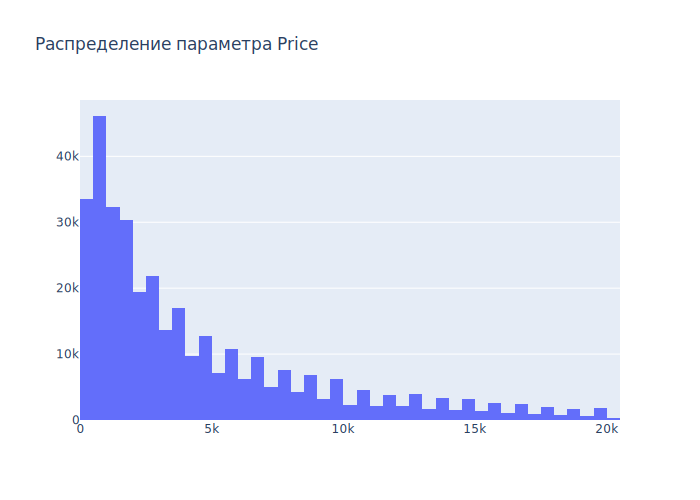

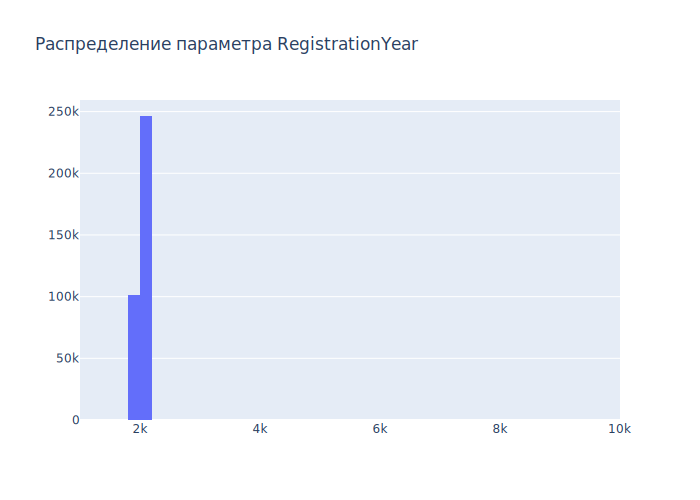

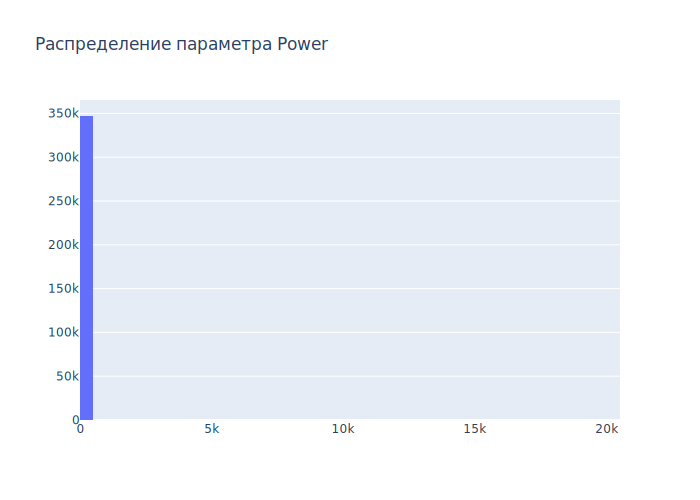

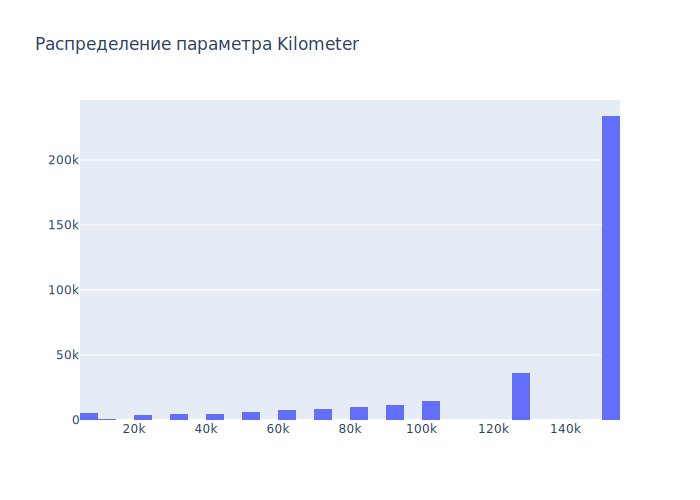

In [38]:
for param in numeric:
    plot_param(df, param)

Price смущает первый столбец 0-500\
RegistrationYear и Power нужно убрать явные выбросы и дальше смотреть\
Kilometer все в порядке


In [39]:
df['RegistrationYear'].describe()

count    347541.000000
mean       2003.714273
std          68.114605
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [40]:
df[df['RegistrationYear'] > 2018]['RegistrationYear'].count()

83

In [41]:
df[df['Power'] > 2500]['Power'].count()

98

Поскольку их счетное количество, проще просто убрать

In [42]:
df = df[df['RegistrationYear'] < 2016]
df = df[df['Power'] < 2500]

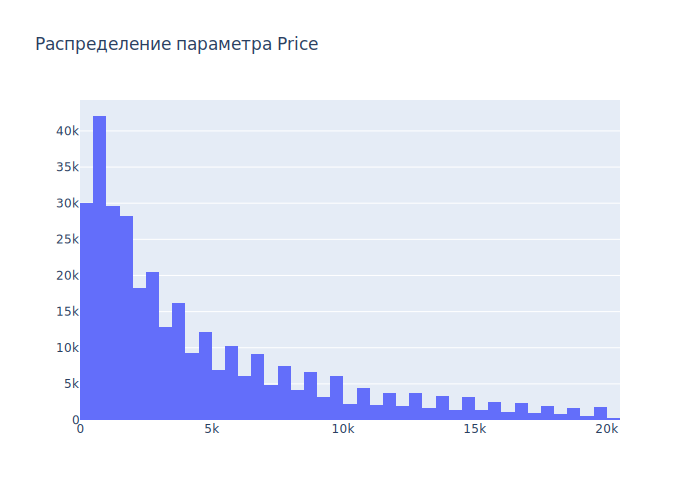

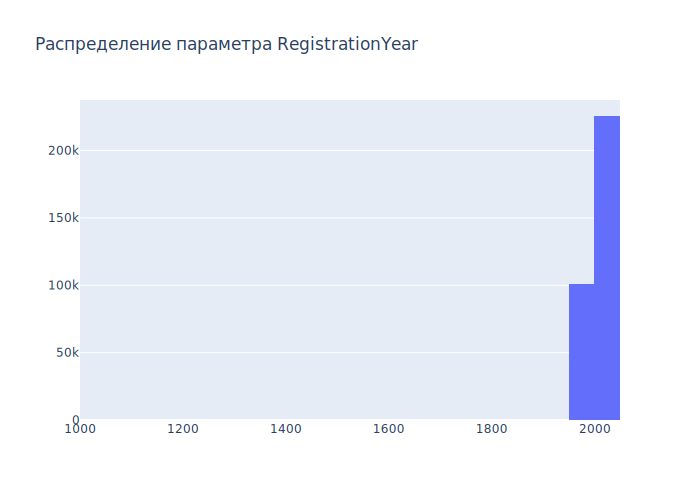

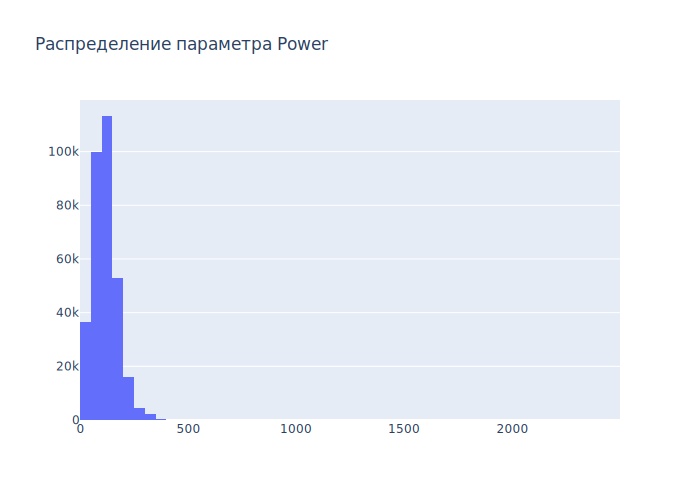

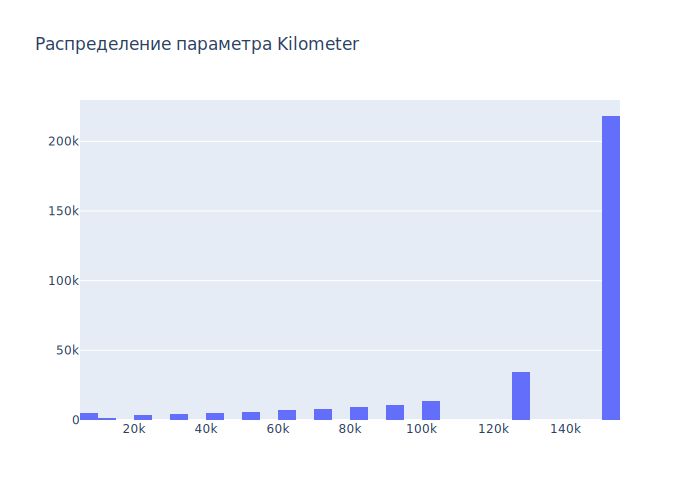

In [43]:
for param in numeric:
    plot_param(df, param)

Price первый столбец буем рассматривать отдельно\
\
RegistrationYear раритеты до 70-ых годов не акутальны для предсказания моделей ввиду своей редкости, заодно и ошибки с невозможными датами уберем\
\
Power существуют серийные автомобили высокой мощности, а вот маломощные авто 0-50 выглядят сомнительно, их нужно изучить

In [44]:
df = df[df['RegistrationYear'] > 1969]

**Price**

Это целевой признак, в нем важнее всего навести порядок

In [45]:
df['Price'].describe()

count    325466.000000
mean       4561.967868
std        4558.646527
min           0.000000
25%        1180.000000
50%        2900.000000
75%        6590.000000
max       20000.000000
Name: Price, dtype: float64

Прежде всего удалим невозможные данные. Таких значений не мало:

In [46]:
df[df['Price'] < 200]['Price'].count()

13866

In [47]:
df = df[df['Price'] > 200]

In [48]:
df[df['Price'] < 500]['Power'].describe()

count    14246.000000
mean        64.523866
std         67.000793
min          0.000000
25%         43.000000
50%         60.000000
75%         90.000000
max       1999.000000
Name: Power, dtype: float64

In [49]:
df[df['Price'] < 500]['Kilometer'].describe()

count     14246.000000
mean     137233.960410
std       33657.191555
min        5000.000000
25%      150000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

Подавляющиее большинство машин маломощные и с большим пробегом. Судя по всему, выше 150тыс пробега поставить нельзя, и на деле цифра может быть еще больше. Для таких случаев цена выглядит уже гораздо реалистичнее.\
Разберем подозрительные данные отдельно

Power

In [50]:
df[(df['Price'] < 500) & (df['Power'] > 40)].describe()

,Price,RegistrationYear,Power,Kilometer
count,10701.000000,10701.000000,10701.000000,10701.000000
mean,356.489767,1997.257826,85.386973,139608.447809
std,76.104229,3.472020,64.876120,29557.815034
min,202.000000,1972.000000,41.000000,5000.000000
25%,300.000000,1995.000000,60.000000,150000.000000
50%,350.000000,1997.000000,75.000000,150000.000000
75%,400.000000,1999.000000,101.000000,150000.000000
max,499.000000,2015.000000,1999.000000,150000.000000


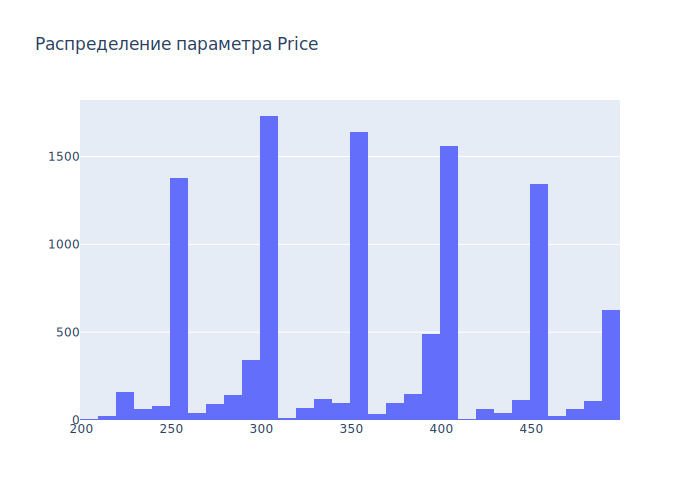

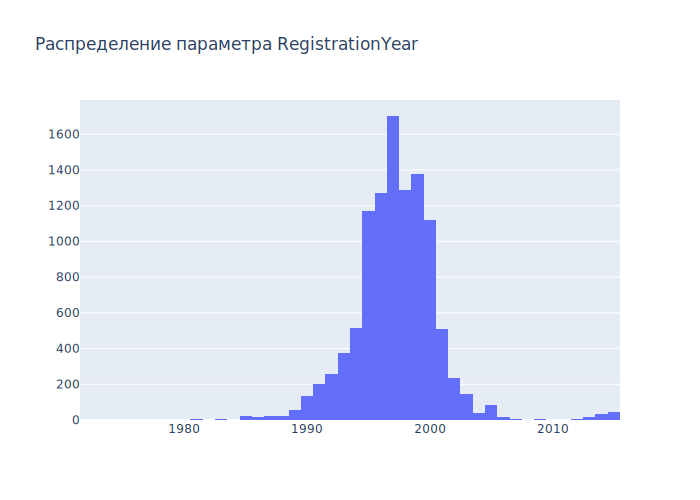

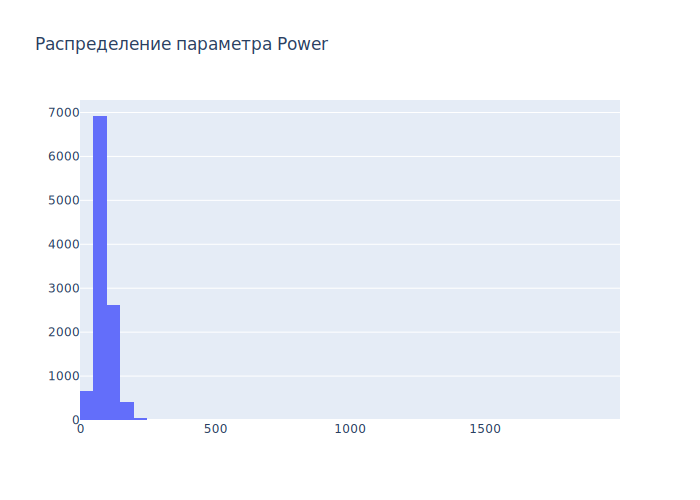

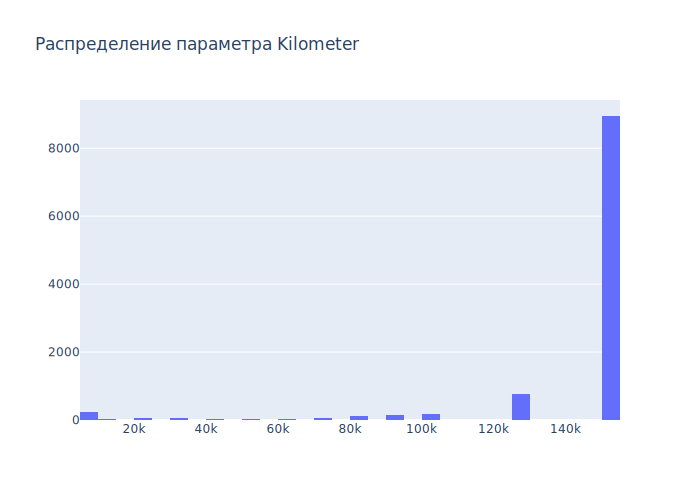

In [51]:
for param in numeric:
    plot_param(df[(df['Price'] < 500) & (df['Power'] > 40)], param)

Выбиваются машины после 2010 года, мощностью более 1000 и километражем менее 120. Поскольку их мало, имеет смысл просто удалить

In [52]:
df_todie = df[(df['Price'] < 500) & ((df['Power'] > 1000) | (df['RegistrationYear'] > 2010) | (df['Kilometer'] < 120000))]


In [53]:
df = pd.merge(df, df_todie, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

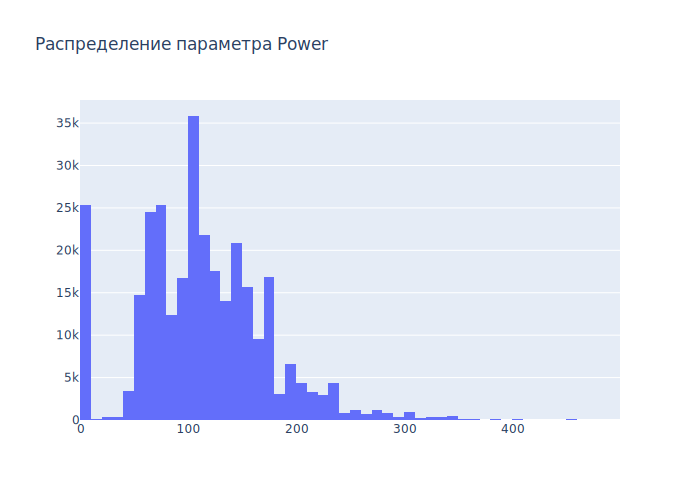

In [54]:
plot_param(df[df['Power'] < 500], 'Power')

In [55]:
df = df.reset_index(drop=True)
dic = {}
for model in df.loc[df['Model'].isna() == False,'Model'].unique():
    dic[str(model)] = df[df['Model'] == model].groupby('Power')['Power'].count().sort_values(ascending=False).head(1).index[0]
    
for i in range(len(df)):
    if df.loc[i, 'Power'] < 40:
        df.loc[i, 'Power'] = dic[df.loc[i, 'Model']]

In [56]:
df[df['Power'] < 40]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
200,500,small,1999,manual,0,unspecified,150000,petrol,renault,no
202,300,small,1994,manual,0,other,150000,petrol,mitsubishi,unspecified
224,300,bus,1997,manual,0,other,150000,petrol,opel,unspecified
322,10200,coupe,2008,manual,0,other,90000,petrol,nissan,unspecified
395,1600,wagon,1999,manual,0,unspecified,150000,petrol,bmw,no
...,...,...,...,...,...,...,...,...,...,...
308012,1500,bus,1984,manual,0,unspecified,150000,gasoline,mercedes_benz,unspecified
308081,4300,small,2008,auto,0,unspecified,150000,unspecified,honda,unspecified
308113,2300,bus,2000,manual,0,other,80000,gasoline,citroen,no
308168,790,sedan,1990,manual,0,other,150000,petrol,renault,unspecified


In [57]:
df = df[df['Power'] > 40]

После всех чисток удалили не настолько большую часть данных

In [58]:
df.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.576992,0.424607,-0.397964
RegistrationYear,0.576992,1.000000,0.117440,-0.366306
Power,0.424607,0.117440,1.000000,0.081536
Kilometer,-0.397964,-0.366306,0.081536,1.000000


### Подготовка выборок для обучения моделей.

In [59]:
or_features = df.select_dtypes(include='object').columns.to_list()
or_features

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [60]:
target = df['Price']
features = df.drop(['Price'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.20, random_state=12345)

features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

In [62]:
enc = OrdinalEncoder()
enc.fit(features_train[or_features])
features_train[or_features] = enc.transform(features_train[or_features])
features_valid[or_features] = enc.transform(features_valid[or_features])
features_test[or_features] = enc.transform(features_test[or_features])

### Обучение моделей

Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.

In [63]:
results = pd.DataFrame({'model': [],
 'fit_time' : [],
 'comp_time': [],
 'rmse': []})

#### LightGBM

Создадим стандартную модель:

In [64]:
begin = time.time()
model_LGBM = LGBMRegressor()
model_LGBM.fit(features_train, target_train)
end = time.time()
fit_time_std_LGBM = round(end - begin)

In [65]:
begin = time.time()
model_LGBM.predict(np.array(features_valid.iloc[0]).reshape(1, -1))
end = time.time()
comp_time_std_LGBM = round(end - begin, 3)

In [66]:
rmse_std_LGBM = mean_squared_error(target_valid, model_LGBM.predict(features_valid)) ** 0.5

In [67]:
results.loc[0] = ['Standart LGBM', fit_time_std_LGBM, comp_time_std_LGBM, rmse_std_LGBM]
results

,model,fit_time,comp_time,rmse
0,Standart LGBM,1,0.0,1621.292855


Подберем наилучшую модель: (после поиска лучших параметров сократила диапазон)

In [68]:
parametrs = {'n_estimators': range(90, 110, 10),
             'learning_rate': np.arange(0.01, 0.2, 0.05),
             'num_leaves': range(32, 36, 2)
             }

In [69]:
def rmse(t,p):
    return mean_squared_error(t,p) ** 0.5
scorer = make_scorer(rmse, greater_is_better=False)

In [ ]:
# %%time
# model_LGBM = LGBMRegressor()
# grid = GridSearchCV(model_LGBM, parametrs, cv=5, verbose=50, scoring=scorer)
# grid.fit(features_train, target_train)
# grid.best_params_

Лучшие параметры {'learning_rate': 0.2, 'n_estimators': 100, 'num_leaves': 34}

In [70]:
begin = time.time()
model_LGBM_b = LGBMRegressor(learning_rate = 0.2, n_estimators = 100, num_leaves = 34)
model_LGBM_b.fit(features_train, target_train)
end = time.time()
fit_time_best_LGBM = round(end - begin)

In [71]:
begin = time.time()
model_LGBM_b.predict(np.array(features_valid.iloc[0]).reshape(1, -1))
end = time.time()
comp_time_best_LGBM = round(end - begin, 3)

In [72]:
rmse_best_LGBM = mean_squared_error(target_valid, model_LGBM_b.predict(features_valid)) ** 0.5

In [73]:
results.loc[1] = ['Best LGBM', fit_time_best_LGBM, comp_time_best_LGBM, rmse_best_LGBM]
results

,model,fit_time,comp_time,rmse
0,Standart LGBM,1,0.000,1621.292855
1,Best LGBM,1,0.001,1563.219003


#### DecisionTreeRegressor

In [74]:
parametrs = {'max_depth': range(3, 11, 2),
             'min_samples_leaf': range(4, 8),
             'min_samples_split': range(2, 6, 2)
             }

In [ ]:
# %%time
# model_tree = DecisionTreeRegressor(random_state=0)
# grid = GridSearchCV(model_tree, parametrs, cv=5, verbose=10, scoring=scorer)
# grid.fit(features_train, target_train)
# grid.best_params_

{'max_depth': 9, 'min_samples_leaf': 7, 'min_samples_split': 2}

In [75]:
begin = time.time()
model_tree = DecisionTreeRegressor(random_state=0)
model_tree.fit(features_train, target_train)
end = time.time()
fit_time_std_tree = round(end - begin)

In [76]:
begin = time.time()
model_tree.predict(np.array(features_valid.iloc[0]).reshape(1, -1))
end = time.time()
comp_time_std_tree = round(end - begin, 3)

D:\Python\lib\site-packages\sklearn\base.py:420: UserWarning:

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names



In [77]:
rmse_std_tree = mean_squared_error(target_valid, model_tree.predict(features_valid)) ** 0.5

In [78]:
results.loc[2] = ['Standart tree', fit_time_std_tree, comp_time_std_tree, rmse_std_tree]

Теперь проверим дерево с лучшими параметрами

In [79]:
begin = time.time()
model_tree_b = DecisionTreeRegressor(random_state=0, max_depth = 9, min_samples_leaf = 7, min_samples_split = 2)
model_tree_b.fit(features_train, target_train)
end = time.time()
fit_time_best_tree = round(end - begin)

In [80]:
begin = time.time()
model_tree_b.predict(np.array(features_valid.iloc[0]).reshape(1, -1))
end = time.time()
comp_time_best_tree = round(end - begin, 3)

D:\Python\lib\site-packages\sklearn\base.py:420: UserWarning:

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names



In [81]:
rmse_best_tree = mean_squared_error(target_valid, model_tree_b.predict(features_valid)) ** 0.5

In [82]:
results.loc[3] = ['Best tree', fit_time_best_tree, comp_time_best_tree, rmse_best_tree]

In [83]:
results

,model,fit_time,comp_time,rmse
0,Standart LGBM,1,0.000,1621.292855
1,Best LGBM,1,0.001,1563.219003
2,Standart tree,1,0.000,1829.254225
3,Best tree,1,0.001,1957.640565


####  Линейная

In [93]:
ohe_features = df.select_dtypes(include='object').columns.to_list()

transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), ohe_features),
    remainder='passthrough')

transformed = transformer.fit_transform(features_train)
transformed = transformed.toarray()
transformed_df_train = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

transformed = transformer.transform(features_valid)
transformed = transformed.toarray()
transformed_df_valid = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

transformed = transformer.transform(features_test)
transformed = transformed.toarray()
transformed_df_test = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

In [94]:
begin = time.time()
model_lr = LinearRegression()
model_lr.fit(transformed_df_train, target_train)
end = time.time()
fit_time_lr = round(end - begin)

In [95]:
begin = time.time()
model_lr.predict(np.array(transformed_df_test.iloc[0]).reshape(1, -1))
end = time.time()
comp_time_lr = round(end - begin, 3)

D:\Python\lib\site-packages\sklearn\base.py:420: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



In [96]:
rmse_best_tree = mean_squared_error(target_valid, model_lr.predict(transformed_df_valid)) ** 0.5

In [97]:
results.loc[4] = ['Linear', fit_time_best_tree, comp_time_best_tree, rmse_best_tree]

#### Dummy

In [98]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
rmse_dummy = mean_squared_error(target_valid, dummy_regr.predict(features_valid)) ** 0.5
rmse_dummy

4525.760202622181

Все модели показали себя лучше константной 

## Анализ моделей

Проанализируйте время обучения, время предсказания и качество моделей.

In [99]:
%%time
cv_res = []
for model in [model_LGBM, model_LGBM_b, model_tree, model_tree_b]:
    cv_results = cross_validate(model, features_valid, target_valid, cv=3, scoring=scorer)
    cv_res.append(cv_results)

CPU times: total: 17 s
Wall time: 2.12 s


In [100]:
i = 0
cv_dic = {}
for model in [model_LGBM, model_LGBM_b, model_tree, model_tree_b]:
    cv_dic[str(model)] = [cv_res[i]['fit_time'].mean(), cv_res[i]['score_time'].mean(), cv_res[i]['test_score'].mean() * (-1)]
    i += 1
    
cv_final = pd.DataFrame.from_dict(cv_dic, orient = 'index', columns = ['fit_time', 'score_time', 'test_score'])
cv_final

,fit_time,score_time,test_score
LGBMRegressor(),0.262688,0.019493,1676.262997
"LGBMRegressor(learning_rate=0.2, num_leaves=34)",0.236824,0.023414,1655.484474
DecisionTreeRegressor(random_state=0),0.109132,0.004144,2328.217836
"DecisionTreeRegressor(max_depth=9, min_samples_leaf=7, random_state=0)",0.040166,0.003385,2065.442661


LGBM проявилась лучше всех. Посчитаем ее rmse:

In [101]:
rmse(target_test, model_LGBM_b.predict(features_test))

1555.6590480120174